In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import javalang
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from collections import Counter
from itertools import chain

import tensorflow as tf
# import tensorflow_addons as tfa # TODO: find ready to use seq2seq modules here
from tensorflow.keras import layers
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

tqdm.pandas()

/home/tony/source/programming-tools/.venv/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


- [ ] Add a start and end token to each sentence.
- [ ] Create a token index and reverse token index (dictionaries mapping from token → id and id → token).
- [ ] Pad each sequence to a maximum length.

In [2]:
data_path = '../data/method-names-rich/elasticsearch.csv'

In [3]:
# TODO: we take only a few samples just to run a single training loop
# TODO: Think data processing through: put data preprocessing in a separate notebook
#      which takes in raw CSV data and spits out tensors?
df = pd.read_csv(data_path).dropna().head(40000)
df.head()

,file_name,class_name,method_name,return_type,arguments,body,documentation,modifiers,annotations
0,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testInvalidBlockQuote,void,[],"{ String input = ""\""foo\"": \""\""\""bar\""""; expec...",None,['public'],[]
1,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testSimpleBlockQuote,void,[],"{ assertEquals(""\""foo\"": \""bort baz\"""", replac...",None,['public'],[]
2,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testMultipleBlockQuotes,void,[],"{ assertEquals( ""\""foo\"": \""bort baz\"", \""bar\...",None,['public'],[]
3,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testEscapingInBlockQuote,void,[],"{ assertEquals(""\""foo\"": \""bort\\\"" baz\"""", re...",None,['public'],[]
4,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testIsDocWriteRequest,void,[],{ assertTrue((boolean) RestTestsFromSnippetsTa...,None,['public'],[]


In [4]:
def split_camel_case(str):
    words = [[str[0]]]
  
    for c in str[1:]: 
        if words[-1][-1].islower() and c.isupper(): 
            words.append(list(c)) 
        else: 
            words[-1].append(c) 
  
    return [''.join(word).lower() for word in words]

print(split_camel_case('transformSearchResponse'))
print(split_camel_case('modifySearchResponseData'))

['transform', 'search', 'response']
['modify', 'search', 'response', 'data']


In [5]:
# TODO: use a smarter identifier splitter
def get_subtokens(token):
    return split_camel_case(token)

def compute_loss(target_token, predicted_token):
    target_subtokens = get_subtokens(target_token) # a.k.a required subtokens
    predicted_subtokens = get_subtokens(predicted_token)
    overlapping = Counter(target_subtokens) & Counter(predicted_subtokens)
    overlapping_count = sum(overlapping.values())
    
    precision = 1.0 * overlapping_count / len(predicted_subtokens)
    recall = 1.0 * overlapping_count / len(target_subtokens)
    f1 = (2.0 * precision * recall) / (precision + recall)
    
    return { 'precision': precision, 'recall': recall, 'f1': f1 }

compute_loss('transformSearchResponse', 'modifySearchResponseData')

{'precision': 0.5, 'recall': 0.6666666666666666, 'f1': 0.5714285714285715}

In [6]:
# define input vocabulary

# TODO: investigate why source code body is not tokenized by javalang
invalid_body_count = 0

def tokenize_method_body(code):
    global invalid_body_count
    
    try:
        return list(map(lambda token: token.value, javalang.tokenizer.tokenize(code)))
    except Exception as e:
        invalid_body_count += 1
        if invalid_body_count % 1000 == 0:
            print(f'invalid_body_count = {invalid_body_count}')
        return []

repeating_body_tokens = pd.Series(chain.from_iterable(
    df.body \
        .progress_apply(tokenize_method_body) \
        .values
))
repeating_body_tokens

invalid_body_count = 1000
invalid_body_count = 2000
invalid_body_count = 3000
invalid_body_count = 4000
invalid_body_count = 5000



0                               {
1                          String
2                           input
3                               =
4          "\"foo\": \"\"\"bar\""
                    ...          
2517179                         (
2517180                      unit
2517181                         )
2517182                         ;
2517183                         }
Length: 2517184, dtype: object

In [7]:
unique_body_tokens = pd.DataFrame.from_dict(Counter(repeating_body_tokens.values), orient='index') \
    .sort_values(by=0, ascending=False) \
    .reset_index().rename(columns={'index': 'token', 0: 'count'})

unique_body_tokens.head(30)

,token,count
0,),344430
1,(,343200
2,.,232659
3,;,160899
4,",",125172
5,{,66712
6,},64885
7,=,53815
8,new,29779
9,return,25712


In [8]:
len(unique_body_tokens[unique_body_tokens['count'] >= 2])

31006

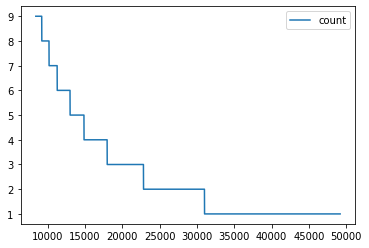

In [9]:
unique_body_tokens[unique_body_tokens['count'] < 10].plot()

In [10]:
unique_body_tokens[unique_body_tokens['count'] == 1].sample(10)

,token,count
44940,"""updating with preVoteResponse={}, leader={}""",1
48549,"""1.7.2""",1
37355,INDEXING,1
39882,84.9992567,1
32567,"""Can't export `""",1
41209,"""network disruption (disruption type: """,1
33680,advanceShallow,1
44476,"""reconfiguration failed""",1
36268,"""alias:i,indices;text-align:right;desc:number ...",1
40176,"""2017-02-01T09:00:00.000-01:00""",1


[Text(0, 0.5, 'Subtoken frequency'),
 Text(0.5, 0, 'Rank by frequency count'),
 Text(0.5, 1.0, 'Distribution of subtoken frequency')]

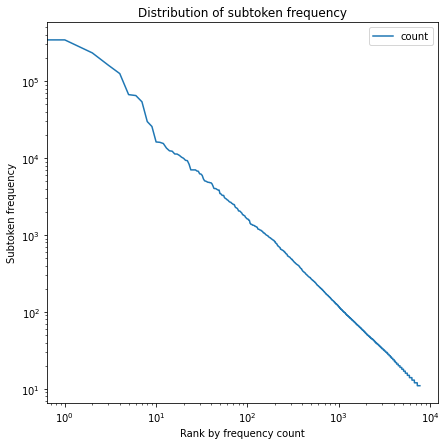

In [11]:
# index by position in the list which is sorted by frequency
ax = unique_body_tokens[unique_body_tokens['count'] > 10] \
    .plot(loglog=True, figsize=(7, 7))
ax.set(title='Distribution of subtoken frequency', xlabel='Rank by frequency count', ylabel='Subtoken frequency')

In [12]:
# # yes, the pandas groupby interface is THIS stupid :) ...
# unique_body_tokens = repeating_body_tokens \
#     .groupby(lambda index: repeating_body_tokens[index]).count()

# unique_body_tokens.head(30)

In [13]:
# define output vocabulary

repeating_method_subtokens = pd.Series(chain.from_iterable(df.method_name.progress_apply(get_subtokens).values))

# yes, the pandas groupby interface is THIS stupid :) ...
unique_method_subtokens = repeating_method_subtokens \
    .groupby(lambda index: repeating_method_subtokens[index]).count() \
    .sort_values(ascending=False)

unique_method_subtokens.head(30)

test        10236
get          5057
to           2686
set          1694
with         1470
create       1398
index        1394
xcontent     1357
field        1266
write        1169
do           1125
from         1096
query        1089
on            889
assert        870
node          859
string        840
name          797
value         791
shard         780
parse         755
equals        702
is            699
type          684
random        683
add           678
and           641
hash          634
code          594
no            587
dtype: int64

[Text(0, 0.5, 'Subtoken frequency'),
 Text(0.5, 0, 'Rank by frequency count'),
 Text(0.5, 1.0, 'Distribution of subtoken frequency')]

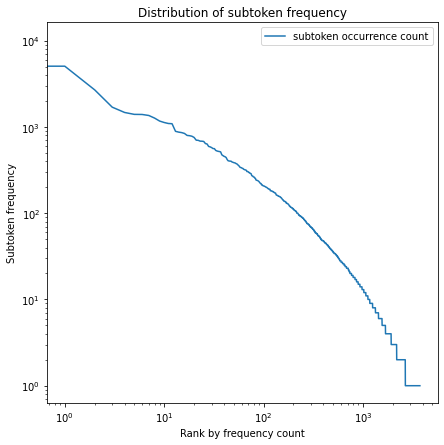

In [14]:
# index by position in the list which is sorted by frequency
ax = unique_method_subtokens \
    .sort_values(ascending=False).reset_index().rename(columns={0: 'subtoken occurrence count'}) \
    .plot(loglog=True, figsize=(7, 7))
ax.set(title='Distribution of subtoken frequency', xlabel='Rank by frequency count', ylabel='Subtoken frequency')

In [15]:
len(unique_method_subtokens)

3741

In [16]:
df_unique_method_name_subtokens = pd.DataFrame.from_dict(Counter(repeating_method_subtokens.values), orient='index') \
    .sort_values(by=0, ascending=False) \
    .reset_index().rename(columns={'index': 'token', 0: 'count'})

df_unique_method_name_subtokens.head(30)

,token,count
0,test,10236
1,get,5057
2,to,2686
3,set,1694
4,with,1470
5,create,1398
6,index,1394
7,xcontent,1357
8,field,1266
9,write,1169


In [17]:
df_unique_method_name_subtokens[df_unique_method_name_subtokens['count'] == 1].sample(10)

,token,count
3588,quoted,1
2776,java8compat,1
3541,acquired,1
2764,transitive,1
3338,observer,1
3679,apicall,1
2932,four,1
2809,cancellations,1
2933,uripattern,1
2975,dictionary,1


In [18]:
# dataset

df['body_tokens'] = df['body'].progress_apply(tokenize_method_body)

# the output sequences are marked with a <start> and <end> special tokens
df['method_name_subtokens'] = df['method_name'].progress_apply(get_subtokens)
df_clean = df[df.body_tokens.str.len() > 0] # remove invalid methods which cannot be parsed

df.head(5)

invalid_body_count = 6000
invalid_body_count = 7000
invalid_body_count = 8000
invalid_body_count = 9000
invalid_body_count = 10000
invalid_body_count = 11000



,file_name,class_name,method_name,return_type,arguments,body,documentation,modifiers,annotations,body_tokens,method_name_subtokens
0,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testInvalidBlockQuote,void,[],"{ String input = ""\""foo\"": \""\""\""bar\""""; expec...",None,['public'],[],"[{, String, input, =, ""\""foo\"": \""\""\""bar\"""", ...","[test, invalid, block, quote]"
1,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testSimpleBlockQuote,void,[],"{ assertEquals(""\""foo\"": \""bort baz\"""", replac...",None,['public'],[],"[{, assertEquals, (, ""\""foo\"": \""bort baz\"""", ...","[test, simple, block, quote]"
2,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testMultipleBlockQuotes,void,[],"{ assertEquals( ""\""foo\"": \""bort baz\"", \""bar\...",None,['public'],[],"[{, assertEquals, (, ""\""foo\"": \""bort baz\"", \...","[test, multiple, block, quotes]"
3,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testEscapingInBlockQuote,void,[],"{ assertEquals(""\""foo\"": \""bort\\\"" baz\"""", re...",None,['public'],[],"[{, assertEquals, (, ""\""foo\"": \""bort\\\"" baz\...","[test, escaping, in, block, quote]"
4,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testIsDocWriteRequest,void,[],{ assertTrue((boolean) RestTestsFromSnippetsTa...,None,['public'],[],"[{, assertTrue, (, (, boolean, ), RestTestsFro...","[test, is, doc, write, request]"



% of method_names being reduced: 0.02317264639181249


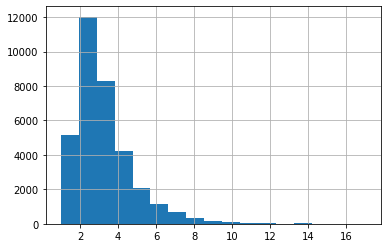

In [19]:
method_name_lengths = df_clean.method_name_subtokens.progress_apply(len)

method_name_lengths.hist(bins=method_name_lengths.max())

# we will add the <start> and <end> tokens which will effectively increase the seq length to 10 during training and prediction
max_decoder_seq_length = 8
number_of_method_names_below_threshold = len(np.where(method_name_lengths.values < max_decoder_seq_length)[0])
print(f"% of method_names being reduced: {1 - number_of_method_names_below_threshold / len(method_name_lengths)}")

In [20]:
# also cut the first max_decoder_seq_length (i.e. 8) subtokens, in order to have a fixed length
method_name_subtokens_with_start_and_end = df_clean['method_name_subtokens'] \
    .progress_apply(lambda tokens: ['<start>'] + tokens[:max_decoder_seq_length] + ['<end>'])

method_name_subtokens_with_start_and_end.progress_apply(len).describe()

count    34394.000000
mean         4.889952
std          1.578746
min          3.000000
25%          4.000000
50%          5.000000
75%          6.000000
max         10.000000
Name: method_name_subtokens, dtype: float64

In [21]:
def get_vocabulary(series):
    all_repeating = pd.Series(chain.from_iterable(series.values))

    return pd.DataFrame.from_dict(Counter(all_repeating.values), orient='index') \
        .sort_values(by=0, ascending=False) \
        .reset_index().rename(columns={'index': 'token', 0: 'count'})

In [22]:
input_vocabulary = get_vocabulary(df_clean.body_tokens)
output_vocabulary = get_vocabulary(method_name_subtokens_with_start_and_end)
len(input_vocabulary), len(output_vocabulary)

(49182, 3360)

In [23]:
# TODO: compute what percentage of the input tokens (including repetition) will be ignored
min_input_token_count = 10
reduced_input_vocabulary = pd.Series(['<UNK>']).append(
    input_vocabulary[input_vocabulary['count'] >= min_input_token_count]['token']
)

In [24]:
ignored_input_tokens_percentage = input_vocabulary[input_vocabulary['count'] < min_input_token_count]['count'].sum() / input_vocabulary[input_vocabulary['count'] >= min_input_token_count]['count'].sum()
print(f'reduced input vocabulary size: {len(reduced_input_vocabulary)}')
print(f'percentage of ignore input: {ignored_input_tokens_percentage}')

reduced input vocabulary size: 8418
percentage of ignore input: 0.04300063893103771


In [25]:
input_token_to_id = { token:id for id, token in enumerate(reduced_input_vocabulary) }
id_to_input_token = reduced_input_vocabulary

In [26]:
len(input_token_to_id), len(id_to_input_token)

(8418, 8418)

In [27]:
output_token_to_id = { token:id for id, token in enumerate(output_vocabulary.token) }
id_to_output_token = output_vocabulary.token

In [28]:
[(key, value) for key, value in output_token_to_id.items()][:10]

[('<start>', 0),
 ('<end>', 1),
 ('test', 2),
 ('get', 3),
 ('to', 4),
 ('set', 5),
 ('create', 6),
 ('xcontent', 7),
 ('index', 8),
 ('with', 9)]

In [29]:
def input_tokens_to_ids(body_tokens):
    return [input_token_to_id[token] if token in input_token_to_id else 0 for token in body_tokens]

In [30]:
def output_tokens_to_ids(output_tokens):
    return [output_token_to_id[token] if token in output_token_to_id else 0 for token in output_tokens]

In [31]:
# raw hyper parameters

max_input_length = 100
max_output_length = method_name_subtokens_with_start_and_end.apply(len).max() # 10

# TODO: limit the input vocabulary size for now
input_vocab_size = 10000 # the number of method body tokens
input_embedding_dim = 50

output_vocab_size = len(output_vocabulary) # used for the softmax layer, like num_classes
output_embedding_dim = 50

latent_dim = 128 # encoder-decoder latent space dimensions

epochs = 10
batch_size=64

In [32]:
method_name_subtoken_ids = method_name_subtokens_with_start_and_end \
    .progress_apply(output_tokens_to_ids)
#     .progress_apply(lambda l: l[-max_output_length:])

method_name_subtoken_ids.progress_apply(len).describe()

count    34394.000000
mean         4.889952
std          1.578746
min          3.000000
25%          4.000000
50%          5.000000
75%          6.000000
max         10.000000
Name: method_name_subtokens, dtype: float64

In [33]:
method_name_subtokens_with_start_and_end[0], method_name_subtoken_ids[0]

(['<start>', 'test', 'invalid', 'block', 'quote', '<end>'],
 [0, 2, 144, 106, 664, 1])

In [34]:
# decoder_inputs
decoder_inputs = method_name_subtoken_ids.progress_apply(lambda seq: seq[:-1])
decoder_inputs

0             [0, 2, 144, 106, 664]
1              [0, 2, 98, 106, 664]
2            [0, 2, 182, 106, 1997]
3        [0, 2, 2056, 52, 106, 664]
4            [0, 2, 24, 39, 11, 36]
                    ...            
39994                   [0, 168, 4]
39996                [0, 94, 11, 4]
39997                    [0, 11, 4]
39998                       [0, 45]
39999                      [0, 566]
Name: method_name_subtokens, Length: 34394, dtype: object

In [35]:
# TODO:
# 1. limit output sequences to a max length
# 2. add <start> and <end> special tokens
# 3. pad the sequencecs
# 4. one hot encode the labels
padded_output_sequences = pad_sequences(
    method_name_subtoken_ids,
    maxlen=max_output_length,
    dtype='int32',
    padding='post',
    truncating='post',
    value=-1 # TODO: 0 is test and not <UNK>
)

padded_output_sequences.shape

(34394, 10)

In [36]:
len(padded_output_sequences)

34394

In [37]:
# decoder_outputs = np.zeros(
#     (len(padded_output_sequences), max_output_length, output_vocab_size),
#     dtype='float32'
# )

indices = []
for seq_id, seq in enumerate(padded_output_sequences):
    for token_index, token_id in enumerate(seq):
        if token_id >= 0: # ignore the -1 padding value in the output sequences
            indices.append([seq_id, token_index, token_id])

tensor_decoder_outputs = tf.SparseTensor(
    indices=indices,
    values=np.ones(len(indices)),
    dense_shape=[len(padded_output_sequences), max_output_length, output_vocab_size]
)
        
tensor_decoder_outputs.shape

TensorShape([34394, 10, 3360])

In [38]:
body_token_ids = df_clean.body_tokens.progress_apply(input_tokens_to_ids).progress_apply(lambda l: l[-max_input_length:])
body_token_ids.progress_apply(len).describe()

count    34394.000000
mean        42.389167
std         37.196231
min          2.000000
25%          9.000000
50%         26.000000
75%         83.000000
max        100.000000
Name: body_tokens, dtype: float64

In [39]:
padded_input_sequences = pad_sequences(
    body_token_ids,
    maxlen=max_input_length,
    dtype='int32',
    padding='pre',
    truncating='pre',
    value=0 # TODO: 0 should be <UNK>
)
padded_input_sequences

array([[0, 0, 0, ..., 1, 4, 7],
       [0, 0, 0, ..., 1, 4, 7],
       [0, 0, 0, ..., 1, 4, 7],
       ...,
       [0, 0, 0, ..., 1, 4, 7],
       [0, 0, 0, ..., 1, 4, 7],
       [0, 0, 0, ..., 1, 4, 7]], dtype=int32)

In [40]:
# X_train, X_test, decoder_inputs_train, decoder_inputs_test, decoder_outputs_train, decoder_outputs_test = train_test_split(
#     padded_input_sequences,
#     decoder_inputs,
#     decoder_outputs,
#     test_size=0.2,
#     random_state=42
# )

# X_train.shape, X_test.shape, decoder_inputs_train.shape, decoder_inputs_test.shape, decoder_outputs_train.shape, decoder_outputs_test.shape

In [41]:
df_body_length = pd.DataFrame.from_dict(Counter(df_clean.body_tokens.apply(len)), orient='index') \
    .reset_index().rename(columns={'index': 'length', 0: 'count'}) \
    .sort_values(by=['length']).set_index('length')

df_body_length.head(5)

,count
length,
2,205
4,1
5,4085
6,71
7,1615


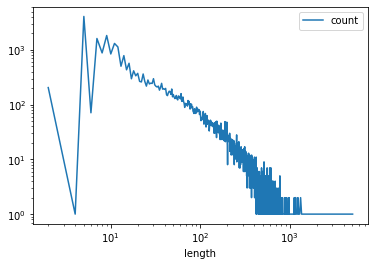

In [42]:
df_body_length.plot(loglog=True)

In [43]:
print(f'number of methods with body token count less than 100: {df_body_length[df_body_length.index < 100]["count"].sum()}')

number of methods with body token count less than 100: 27088


In [44]:
df_clean.body_tokens.apply(len).describe()

count    34394.000000
mean        73.186719
std        128.572999
min          2.000000
25%          9.000000
50%         26.000000
75%         83.000000
max       5044.000000
Name: body_tokens, dtype: float64

In [45]:
df_clean.method_name_subtokens.apply(len).describe()

count    34394.000000
mean         2.920684
std          1.707371
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         17.000000
Name: method_name_subtokens, dtype: float64

In [46]:
# define model: input embedding > LSTM encoder > LSTM decoder > softmax

In [47]:
# TODO: use hyper parameters
# HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
# HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
# HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

In [48]:
def build_model():
    encoder_input = layers.Input(shape=(None, ), name='encoder_input')
    encoder_embeddeding = layers.Embedding(
        input_dim=input_vocab_size,
        output_dim=input_embedding_dim,
        name='encoder_embedding'
    )(encoder_input)

    # Return states in addition to output
    _encoder_output, state_h, state_c = layers.LSTM(
        latent_dim,
        return_state=True,
        name='encoder_lstm'
    )(encoder_embeddeding)
    
    encoder_states = [state_h, state_c]

    decoder_input = layers.Input(shape=(None, ), name='decoder_input')
    decoder_embeddeding = layers.Embedding(
        input_dim=output_vocab_size,
        output_dim=output_embedding_dim,
        name='decoder_embeddeding'
    )(decoder_input)
    
    # Pass the 2 states to a new LSTM layer, as initial state
    decoder_outputs, _, _ = layers.LSTM(
        latent_dim,
        return_sequences=True,
        return_state=True,
        name='decoder_lstm'
    )(decoder_embeddeding, initial_state=encoder_states)
    
    output = layers.Dense(
        output_vocab_size,
        activation='softmax',
        name='softmax'
    )(decoder_outputs)

    model = tf.keras.Model([encoder_input, decoder_input], output)
    return model

In [49]:
model = build_model()

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, None, 50)     500000      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_embeddeding (Embedding) (None, None, 50)     168000      decoder_input[0][0]              
______________________________________________________________________________________________

In [50]:
padded_decoder_inputs = pad_sequences(
    decoder_inputs,
    maxlen=max_output_length,
    dtype='int32',
    padding='post',
    truncating='post',
    value=1 # TODO: 0 should be <UNK>
)
padded_decoder_inputs

array([[  0,   2, 144, ...,   1,   1,   1],
       [  0,   2,  98, ...,   1,   1,   1],
       [  0,   2, 182, ...,   1,   1,   1],
       ...,
       [  0,  11,   4, ...,   1,   1,   1],
       [  0,  45,   1, ...,   1,   1,   1],
       [  0, 566,   1, ...,   1,   1,   1]], dtype=int32)

In [51]:
padded_decoder_inputs.shape

(34394, 10)

In [52]:
tensor_encoder_inputs = tf.convert_to_tensor(padded_input_sequences)

In [53]:
tensor_decoder_inputs = tf.convert_to_tensor(padded_decoder_inputs)

In [54]:
# tensor_decoder_outputs = tf.convert_to_tensor(decoder_outputs)

In [55]:
tensor_encoder_inputs.shape, tensor_decoder_inputs.shape, tensor_decoder_outputs.shape

(TensorShape([34394, 100]),
 TensorShape([34394, 10]),
 TensorShape([34394, 10, 3360]))

In [56]:
# TODO: WTF https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio
# see https://www.tensorflow.org/guide/effective_tf2#use_tfconfigexperimental_run_functions_eagerly_when_debugging
tf.config.experimental_run_functions_eagerly(True)

In [57]:
history = model.fit(
    [tensor_encoder_inputs, tensor_decoder_inputs],
    tf.sparse.to_dense(tensor_decoder_outputs),
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2
)

history

Train on 27515 samples, validate on 6879 samples
Epoch 1/10
16640/27515 [=================>............] - ETA: 1:09 - loss: 4.0368 - accuracy: 0.3106

KeyboardInterrupt: 

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir ../logs

In [ ]:
df_train.method_name_subtokens.shape

In [ ]:
test_loss, test_acc = model.evaluate(test_x, test_y)

In [ ]:
prediction = class_names[np.argmax(model.predict(test_x[0]))]
prediction

In [ ]:
# encoder_input = layers.Input(shape=(None, ))
# encoder_embedded = layers.Embedding(input_dim=input_vocab_size, output_dim=input_embedding_dim)(encoder_input)

# # Return states in addition to output
# output, state_h, state_c = layers.LSTM(latent_dim, return_state=True, name='encoder')(encoder_embedded)
# encoder_state = [state_h, state_c]

# decoder_input = layers.Input(shape=(None, ))
# decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(decoder_input)

# # Pass the 2 states to a new LSTM layer, as initial state
# decoder_output = layers.LSTM(decoder_units, name='decoder')(decoder_embedded, initial_state=encoder_state)
# output = layers.Dense(10, activation='softmax')(decoder_output)

# model = tf.keras.Model([encoder_input, decoder_input], output)

# model.compile(loss='categorical_crossentropy',
#               optimizer='sgd',
#               metrics=['accuracy'])

# model.summary()